# Applied Machine Learning with Scikit Learn - Regressions



### Libraries

- [scikit-learn](http://scikit-learn.org/stable/)




In [9]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from random import randrange

import re
from pprint import pprint

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

%matplotlib inline


## Question 1: Propensity score matching

*In this exercise, we will apply [propensity score matching]

*We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.*

### Dataset description

614 samples with features:

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

In [20]:
lalonde = pd.read_csv('lalonde.csv', index_col=0)
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1. A naive analysis

*Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").*

*What might a naive "researcher" conclude from this superficial analysis?*

Let's describe the variable `re78`:

In [5]:
lalonde.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,6984.169742,7294.161791,0.0,220.1813,4975.505,11688.820,25564.67
1,185.0,6349.143530,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


In [6]:
def plot_distribution(df, feature, title):
    """
    Plot the groups distribution of one feature in the dataframe df
    """
    f, ax = plt.subplots(1)
    f.set_size_inches(16, 8)
    
    df["all_groups"] = ""
    violin = sns.violinplot( x='all_groups', y=feature, hue='treat', 
                            data=df, inner="quartile", 
                            split=True, cut=0, ax = ax )
    violin.set_title(title)
    violin.set_xlabel("")

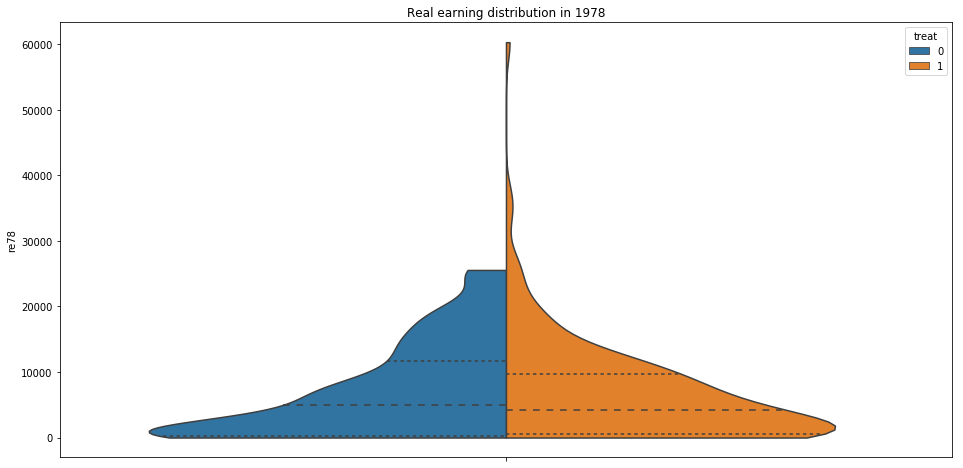

In [7]:
plot_distribution(lalonde,'re78','Real earning distribution in 1978')

This is interesting to see that the mean and the median are better for the control group in 1978. Even if the maximal earning is a subject from the treated group, it seems to be a outlier. We can also see that the last quartile is way higher for the control group. Does that mean that the treatment is not efficient? ;)

### 2. A closer look at the data

*You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.*

*For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.*

*What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.*

#### Real earning distribution

In [8]:
class RealEarning():  
    """
    Class to display the real earning distribution.
    """
    def __init__(self, df):
        self.df = df[["treat","re74","re75","re78"]]
        self.realEarning = pd.melt(df[["treat","re74","re75","re78"]],
                                   id_vars=['treat'],
                                   value_vars=["re74","re75","re78"],
                                   var_name='re_year',
                                   value_name='re')
        
    def plot_distribution(self):
        f,ax = plt.subplots(1)
        f.set_size_inches(16, 12)
        # We choose to use the violin visialization because the distribution in regrouped around zero
        sns.violinplot(x="re_year", y="re",hue="treat",cut=0,
                       title="Real earning distribution whitout unempoyed",
                       data=self.realEarning,inner="quartile")
        
    def plot_distribution_without_unemployed(self):
        f, ax = plt.subplots(1)
        f.set_size_inches(16, 12)
        df = self.realEarning.loc[self.realEarning.re != 0] 
        sns.violinplot(x="re_year", y="re",hue="treat",cut=0,
                       title="Real earning distribution whitout unempoyed",
                       data=df,inner="quartile")

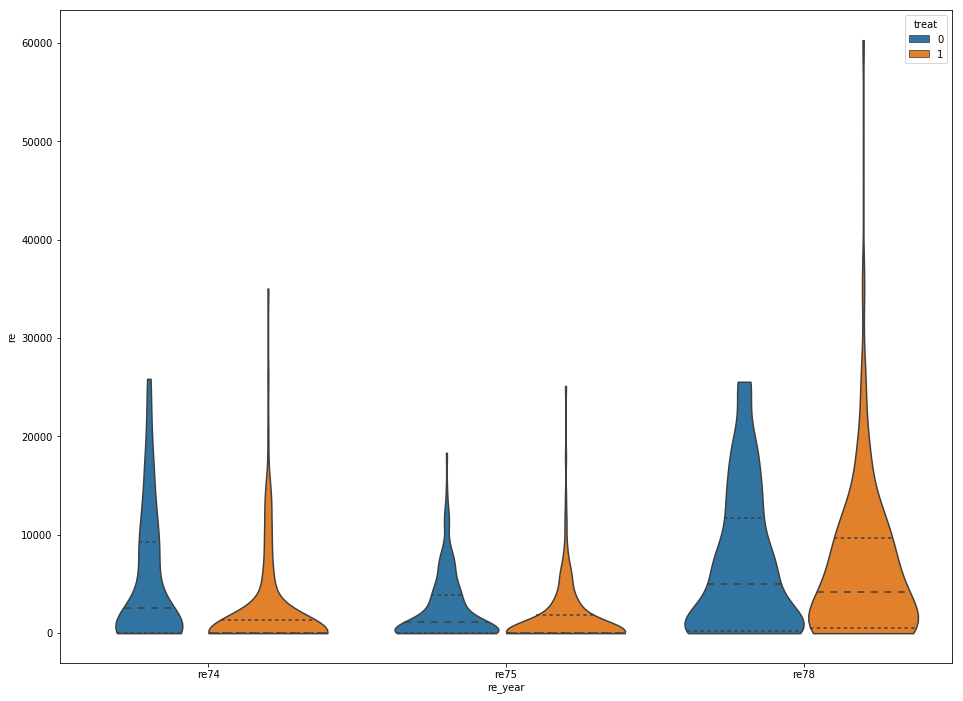

In [9]:
real_earning = RealEarning(lalonde)
real_earning.plot_distribution()

The real earning distribution is really different in 1974 and 1975. In the treated group, the median is around zero and 75% of the subjects of the group earn less than $3000 in 1974 and 1975. What is interesting to see is that for both group the real earning decrease in 1975 compared to 1974. We can explain that by the [73-75 recession](https://en.wikipedia.org/wiki/1973%E2%80%9375_recession).


### Unemployment
We think that is important to take a look at the umployment rate of the two groups.In order to do that, we assume that when you have no income, you are unemployed.

In [10]:
class Unemployment():  
    """
    Class to commpute the unemployment rate in a given dataset
    We assume that when you have no income, you are unemployed.
    """
    def __init__(self, df):
        total = df.groupby('treat').re78.count()
        unemployment74 = df.loc[df.re74==0].groupby('treat')["age"].count()/total
        unemployment75 = df.loc[df.re75==0].groupby('treat')["age"].count()/total
        unemployment78 = df.loc[df.re78==0].groupby('treat')["age"].count()/total
        self.unemploymentRate = pd.DataFrame([unemployment74,unemployment75,unemployment78],
                                              ['unemployment in 74',' unemployment in 75','unemployment in 78'])
    def plot(self):
        f, ax = plt.subplots(1, figsize = (16,8))
        self.unemploymentRate.plot(kind="bar", ax=ax)
        ax.set_title("Umempoyment rate", fontsize = 18 )
        ax.legend(["control","treated"])
        ax.set_xticklabels( ['Unemployment in 74',' Unemployment in 75','Unemployment in 78'] , rotation = 0, ha="center")

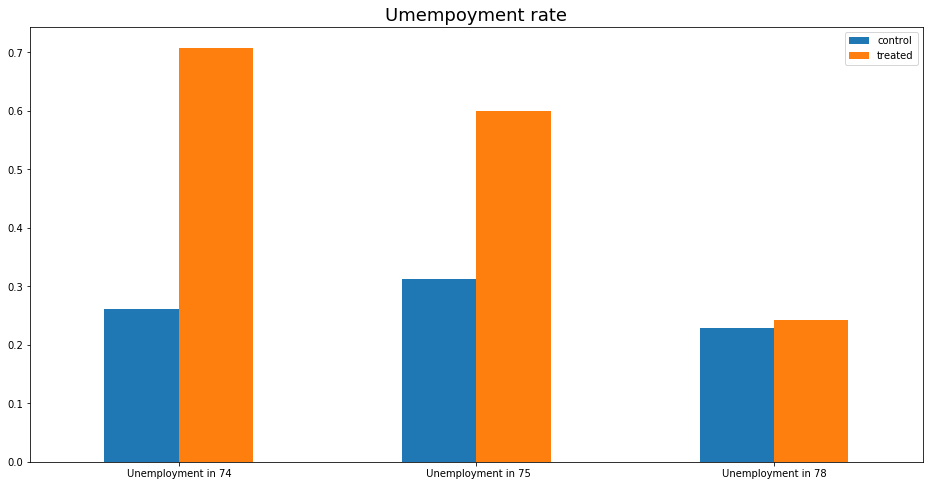

In [11]:
Unemployment(lalonde).plot()

We can see that the distribution is very different in 1974 and 1975, when we look the unemployment rate. This explains the huge difference of earning between the two groups in 1974 and 1975.
#### Age distribution

In [12]:
lalonde.groupby('treat')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,28.030303,10.786653,16.0,19.0,25.0,35.0,55.0
1,185.0,25.816216,7.155019,17.0,20.0,25.0,29.0,48.0


We can see some differences in those two groups. The average and the variance are quite differents. Now let's take a look on the distribution.

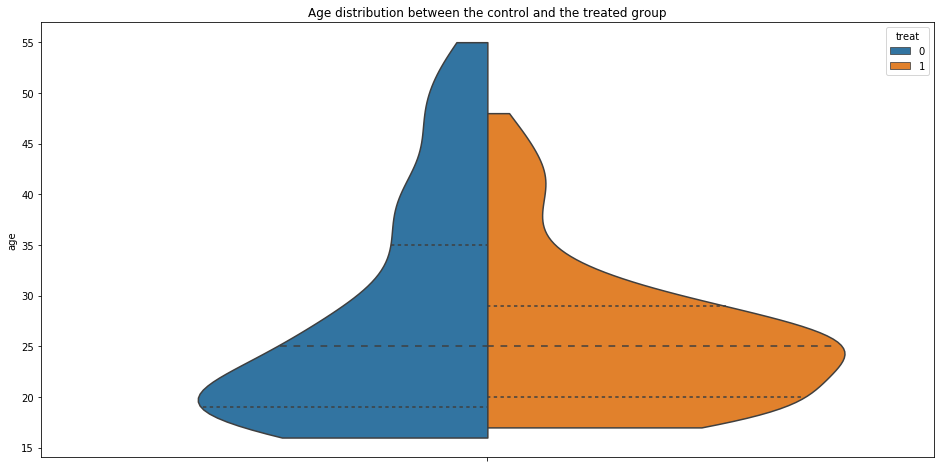

In [43]:
plot_distribution(lalonde,'age','Age distribution between the control and the treated group')

The age distribution for both classes is quite different. The distribution of the treated group is more centered around the median while the distribution of the control group is way more extended. The treated group is younger that the control group and it could be an important metric in this study. We can expect that a young individual has more opportunity to raise is salary.
#### Categorical distributions
Let's plot all the categorical distribution together:

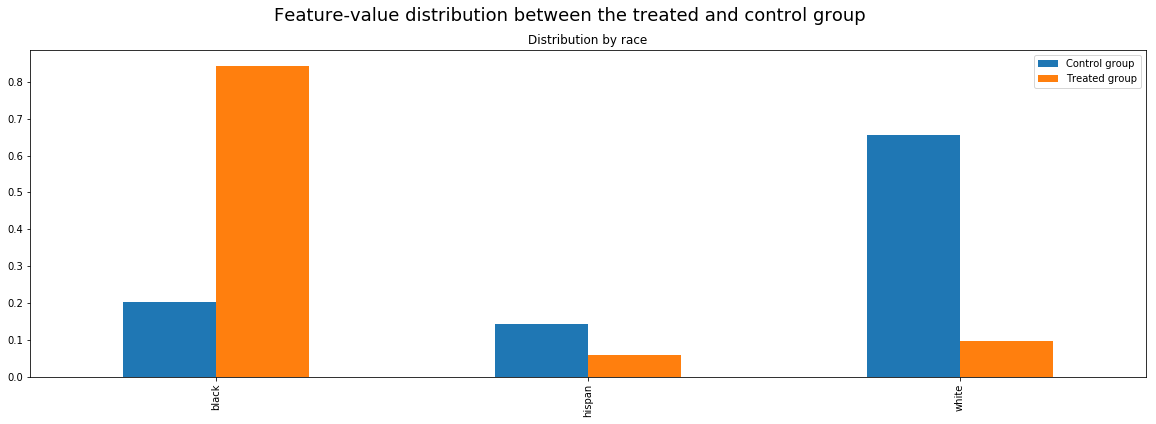

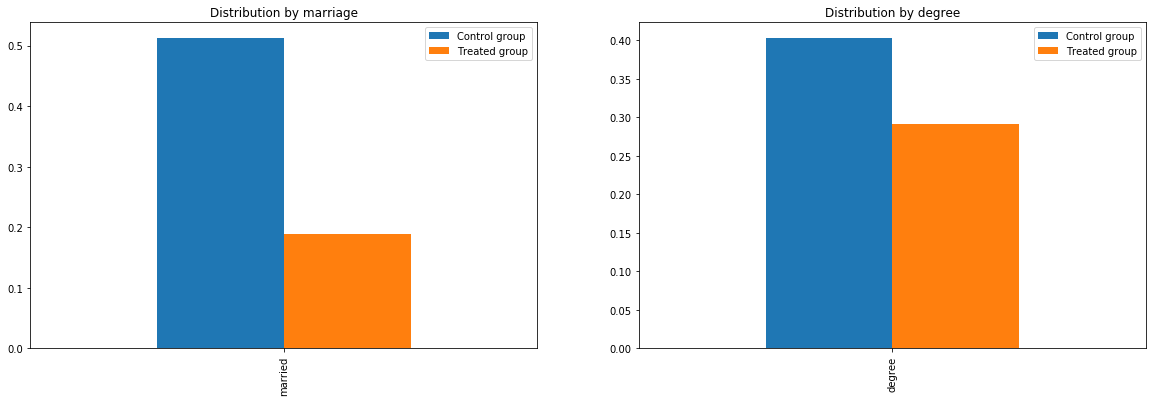

In [14]:
def plot_categorical_distribution( df ) : 
    """
    Plot the distribution of subjects between the 2 groups by race, marriage and degree 
    """
    f, ax = plt.subplots(1, figsize = (20,6))
    f.suptitle("Feature-value distribution between the treated and control group", fontsize=18)
    
    ### race
    race = pd.pivot_table(df, values=['black','hispan'], columns=['treat'])
    race.loc['white'] = 1 - (race.loc['black'] + race.loc['hispan'])
    race.plot(kind='bar', ax=ax)
    
    ax.set_title("Distribution by race")
    ax.set_xlabel("")
    ax.legend(["Control group","Treated group"])
    
    f, ax = plt.subplots(nrows=1,ncols=2, figsize = (20,6))
    ### marriage
    married = pd.pivot_table(df, values=['married'], columns=['treat'])
    married.plot(kind='bar', ax=ax[0])
    
    ax[0].legend(["Control group","Treated group"])
    ax[0].set_title("Distribution by marriage")
    ax[0].set_xlabel("")
    
    
    ### degree
    df["degree"] = 1 - df["nodegree"]
    degree = pd.pivot_table(df, values=['degree'], columns=['treat'])
    degree.plot(kind='bar', ax=ax[1])
    
    ax[1].legend(["Control group","Treated group"])
    ax[1].set_title("Distribution by degree")
    ax[1].set_xlabel("")
    
plot_categorical_distribution(lalonde)

- #####  Race distribution: 
We can see that the distribution per race is not the same at all. Even if the US racial segregation officially stopped in 1967, we can assume that the race is still an important metric in the 70's.
- #### 	Marriage distribution:
The difference between the two groups is huge, 51% of the subject the control group are married wheras only 19% of the treated group are married. We can easily imagine that the marriage can have a huge effect on the real earnings of an individual. 
- #### Degree distribution
The percentage of individuals who has a degree is very different in the 2 groups. It could definitely affect the result of the study.
#### Education distribution

In [15]:
lalonde.groupby('treat')['educ'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,10.235431,2.855238,0.0,9.0,11.0,12.0,18.0
1,185.0,10.345946,2.010650,4.0,9.0,11.0,12.0,16.0


It is interesting to see that the mean and the variation are quite similar. Now let's take a look on the distribution.

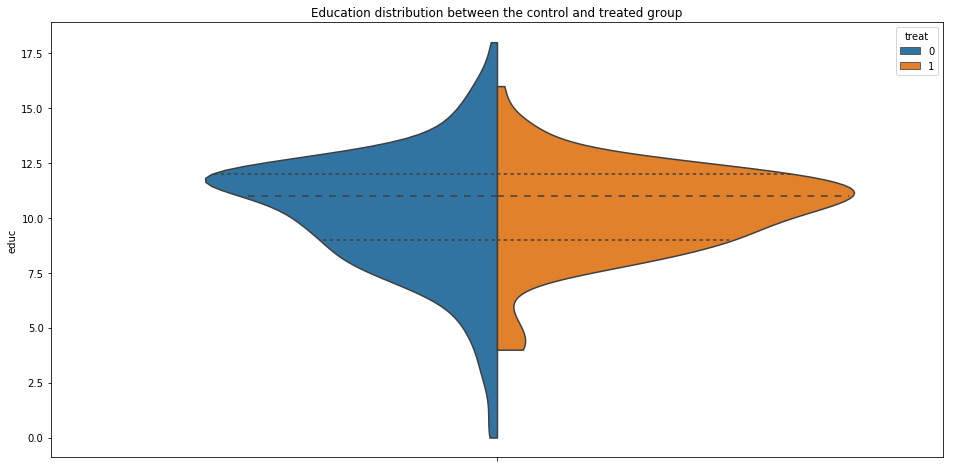

In [44]:
plot_distribution(lalonde,'educ','Education distribution between the control and treated group')

The distribution is quite similar but we can see that the distribution of the treated group is more centered around the mean,  while the distribution of the control group is way more extended. The extremum could have a huge importance on the study.

#### Summary

We can notice that some metrics have a really different distribution. But we noticed that the 2 main differences are about the **race** and **the unemployment**. We will use those two metrics on the part 5.


### 3. A propsensity score model

*Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:*

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

*Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).*

*Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)*

In [21]:
def compute_propensity(df) : 
    """
    Function to compute the propensity score
    of the entire dataset given as parameter
    """

    # Create the model 
    logistic = LogisticRegression() 
    X = df.loc[:, df.columns != 'treat']
    y = df.treat
    # Train the model
    logistic.fit(X, y)

    prediction = logistic.predict_proba(X)

    df['propensity_score'] = pd.Series(logistic.predict_proba(X)[:, 0],index=df.index)

    return df

In [22]:
lalonde = compute_propensity(lalonde)
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.541926
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.848020
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.249034
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.325980
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.329410



Let's plot the distribution of the protensity score.

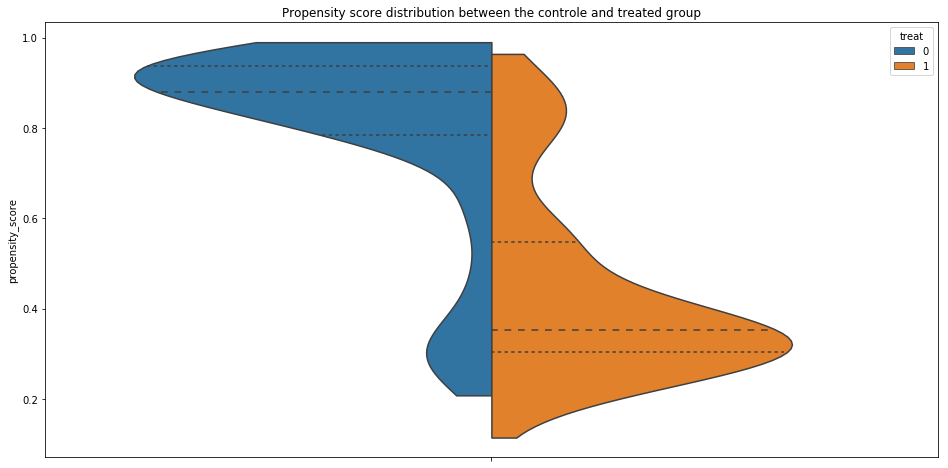

In [45]:
control_group=lalonde[lalonde.treat==0]
treated_group=lalonde[lalonde.treat==1]

df = control_group.append(treated_group)

plot_distribution(df,'propensity_score','Propensity score distribution between the controle and treated group')

### 4. Balancing the dataset via matching

*Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)*

*Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.*

*After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).*

*Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?*

In order to match exactly one subject of the treated group to one subject of the control group we write a function `match`. It uses the networkx library to compute a maximum-weighted matching of a given dataframe and return the matched dataframe built.

In [24]:
import networkx as nx

def match( df) :
    """
    Function to match each data point from the treated group
    with exactly one data point from the control group 
    """
    
    control_group=df[df.treat==0]
    treated_group=df[df.treat==1]

    graph_matches = nx.Graph()

    for control_index, control_row in control_group.iterrows():
        graph_matches.add_node(control_index)
        for treated_index, treated_row in treated_group.iterrows():
            graph_matches.add_node(treated_index)
            # compute the weight
            # 1 - distance
            weight = 1 - np.abs(treated_row.propensity_score - control_row.propensity_score)
            graph_matches.add_edge(control_index, treated_index, weight=weight)

    matches_list = nx.max_weight_matching(graph_matches)

    matched = pd.DataFrame()
    for key,value in matches_list.items():
        matched = matched.append(df.loc[key])

    return matched

Let's apply that matching function to our previous dataframe `lalonde`.

In [25]:
data = match( lalonde)
data.head()

,age,black,educ,hispan,married,nodegree,propensity_score,re74,re75,re78,treat
PSID392,17.0,1.0,10.0,0.0,0.0,1.0,0.309911,0.0,0.0,0.0,0.0
NSW31,17.0,1.0,10.0,0.0,0.0,1.0,0.309911,0.0,0.0,0.0,1.0
PSID374,18.0,1.0,11.0,0.0,0.0,1.0,0.332585,0.0,0.0,0.0,0.0
NSW53,18.0,1.0,11.0,0.0,0.0,1.0,0.332585,0.0,0.0,0.0,1.0
PSID373,20.0,1.0,12.0,0.0,0.0,0.0,0.338912,0.0,0.0,0.0,0.0


We can display the distribution of subjects between the 2 groups by race, marriage and degree for this matched dataframe to make sure that the distribution between the two groups is better balanced.

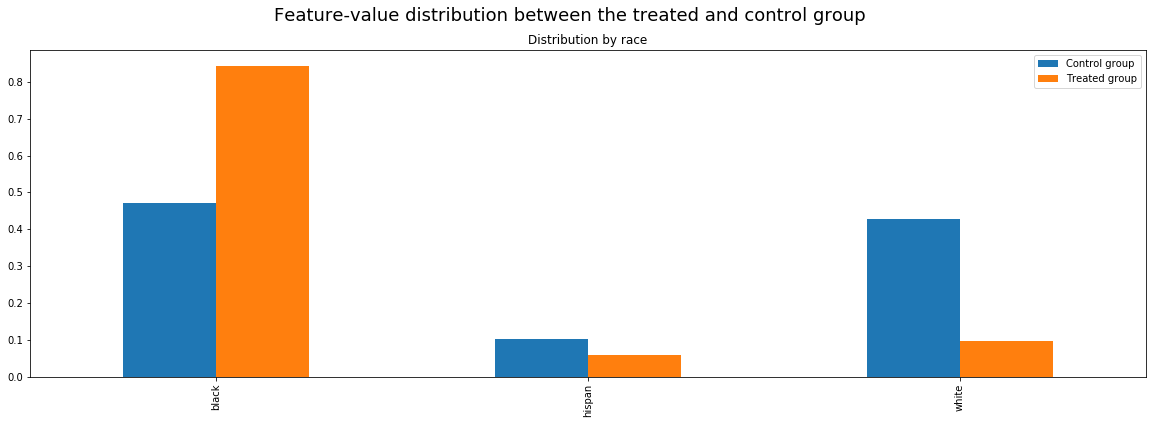

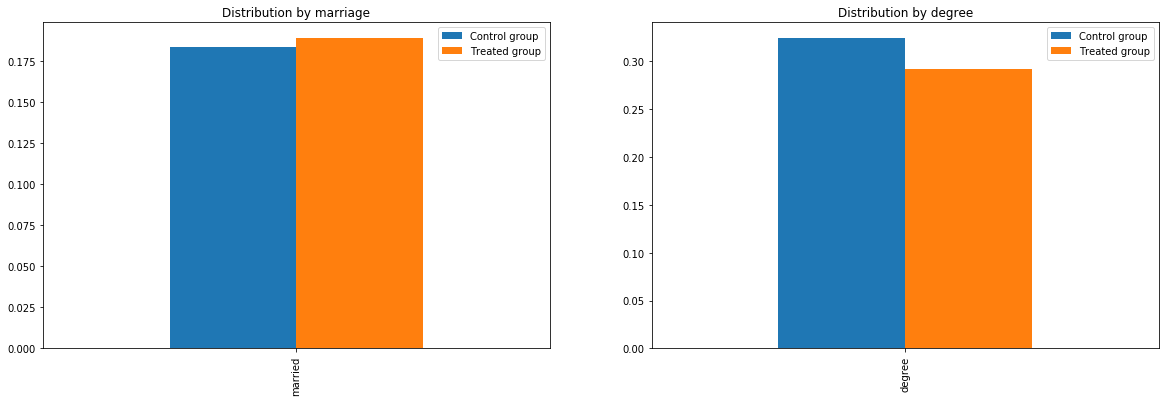

In [26]:
plot_categorical_distribution( data )

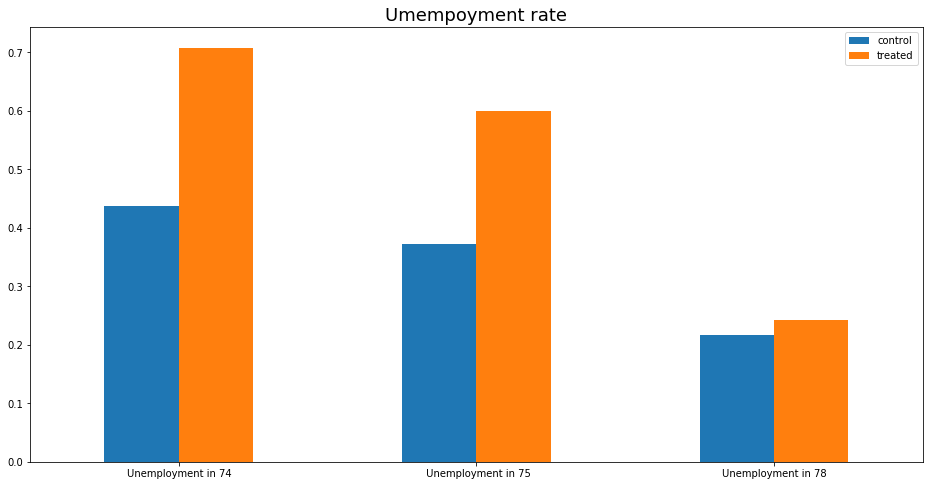

In [29]:
Unemployment(data).plot()

As we can see, after the matching that the distribution is a little bit more balanced but we still can see a difference for the race and the unemployment.

In [30]:
data.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0.0,185.0,5828.584903,6094.306306,0.0,237.9140,4112.513,8957.978,25564.67
1.0,185.0,6349.143530,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


We have matched the 185 subjects of the treated group to exactly one subject on the control group. 

From this matching we cannot really conclude about the efficiency of the program since the mean in the earning of 1978 and the distribution ( shown below ) are similar for both groups.

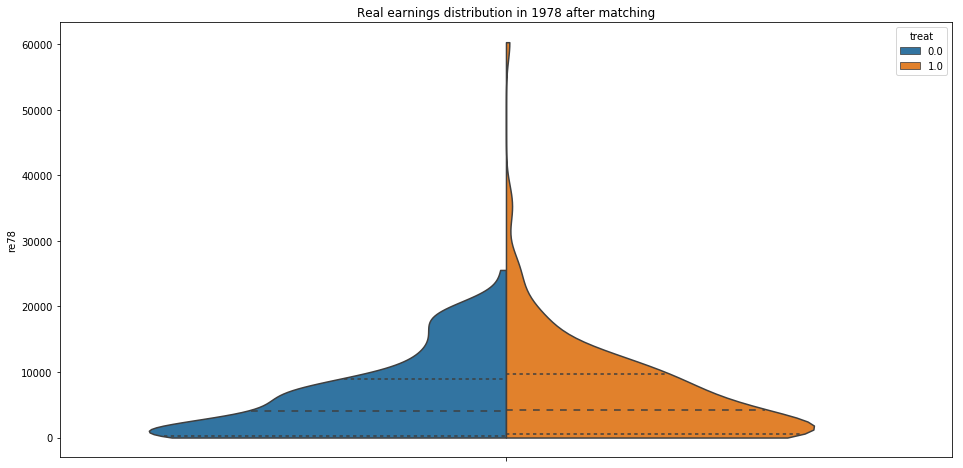

In [48]:
plot_distribution(data,'re78','Real earnings distribution in 1978 after matching')

If we had stopped the analysis here, we would have concluded that the program fails to produce any earnings gain but as we have seen above, the dataset is no perfectly balanced yet.

### 5. Balancing the groups further

*Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?*

*Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.*


#### Process

The matching done in Part 4 shows that the dataset is now better balanced than in Part 2. The distribution of subject by race between the control and treated groups can still be improved. There is still more black people in the treated group than in the control group and the major part of the white subjects are part of the control group.

From part 4, we have evaluated the **race as the problematic feature**.

In order to better balance the dataset, we will match : 
- exactly 1 black person in the control group to 1 black person in the treated group
- exactly 1 non black person in the control group to 1 non black person in the treated group

In [32]:
"""
Match only black people
"""
black_unemployed = data[(data['black'] == 1) & (data['re75'] == 0)]
matched_black_unemployed = match(black_unemployed)

"""
Match only black people
"""
black_non_unemployed = data[(data['black'] == 1) & (data['re75'] > 0)]
matched_black_non_unemployed = match(black_non_unemployed)


"""
Match not black people
"""
not_black_unemployed = data[data['black'] == 0 & (data['re75'] == 0)]
matched_not_black_unemployed = match(not_black_unemployed)

"""
Match not black people
"""
not_black_non_unemployed = data[data['black'] == 0 & (data['re75'] > 0)]
matched_not_black_non_unemployed = match(not_black_non_unemployed)


"""
Build a better balanced dataset
"""
matched = matched_black_unemployed.append([matched_black_non_unemployed,
                                           matched_not_black_unemployed,
                                           matched_not_black_non_unemployed])

In [38]:
matched.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0.0,145.0,5953.668581,6635.126243,0.0,54.67588,3683.972,9088.018,25564.67
1.0,145.0,7009.277366,7124.976503,0.0,1294.40900,5112.014,10363.270,36646.95


We have narrowed down the dataset to **145 subjects on each group** instead of 185 on the previous dataset.
The description of the dataset above clearly shows that the race of the subject has a major influence on the salary. Since our dataset was not balanced we couldn't have an efficient representation. With a better balanced dataset we can clearly see that salary of subjects from the treated group ( mean = 6201 )  is higher than people from the control group ( mean = 5334 ). 

We can see that the two groups are better balanced by plotting the distribution of subjects between the 2 groups by race, marriage and degree, as we did above in part 2 and 4.

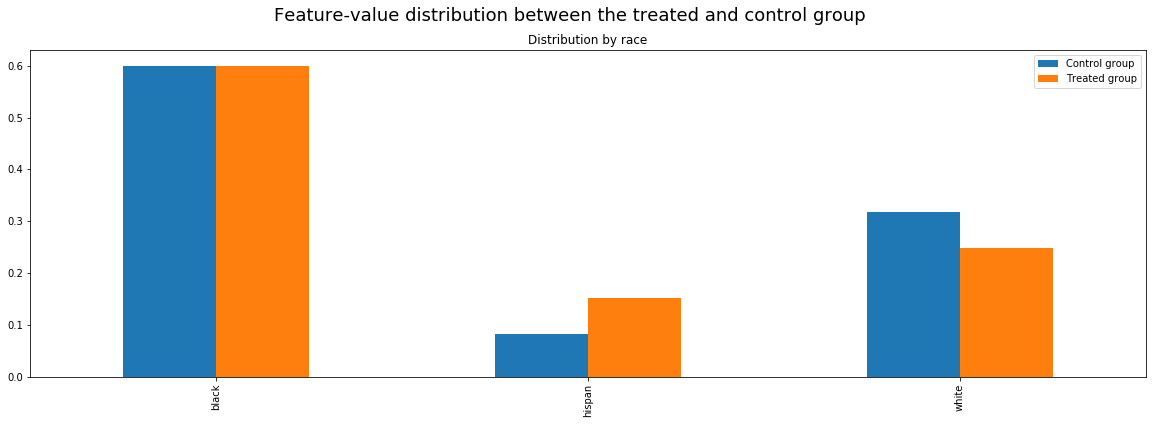

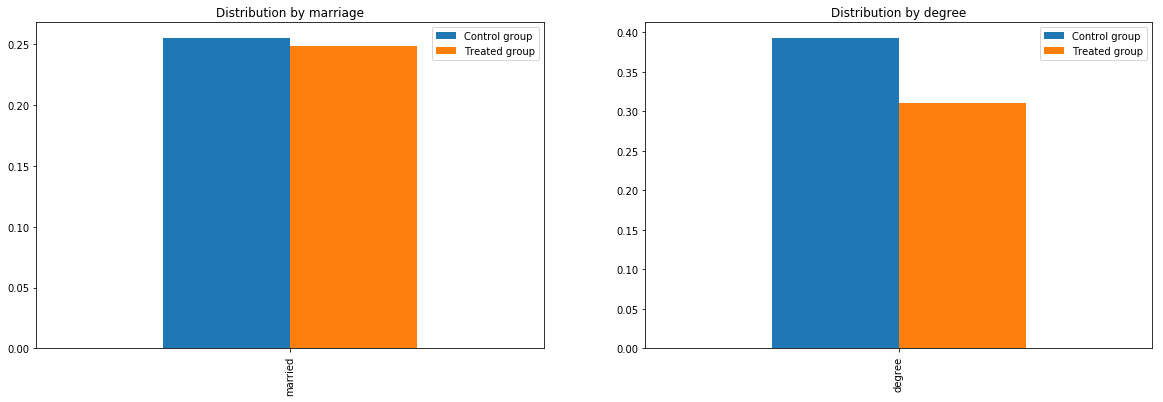

In [39]:
plot_categorical_distribution( matched )


### 6. A less naive analysis

*Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?*

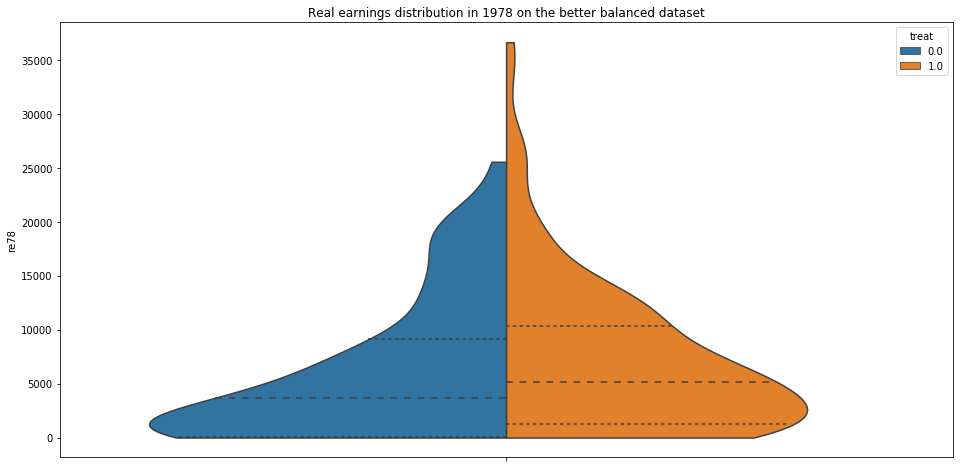

In [49]:
plot_distribution(matched,'re78','Real earnings distribution in 1978 on the better balanced dataset')

Now we clearly see that the training program produces an increase of the real earnings in 1978 on the treated group. To reach this conclusion, we had to shrink the dataset of 614 subjects down to 290.

This teaches us that, the quantity of data doesn't always improve the quality of the observational study. If your data are not correctly balanced, this can lead you to draw the wrong conclusion.

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. 

### Task 1

**Load the data**

Using the sklearn librairy, we loaded the 20newsgroup dataset, composed 11314 articles on 20 topics.

**TF-IDF**

TF-IDF, short for term frequency–inverse document frequency is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF).
It transformed our dataset in high dimensional vector containing the TF-IDF score for each word containing in the article. Our data set has after that 101631 features. But we will see that The extracted TF-IDF vectors are very sparse.

**Split the dataset into a training, a testing and a validation set**

We splited our dataset into 3 different subsets: 
- a training set with 80% of the data
- a testing set with 10% of the data 
- a validation  with 10% of the data 
And to pair each observation (X) with it's label(y), we created a dataframe for each of those subset. The aim of the validation set is to tuned the hyperparamter of the classifier without biasing the results. We trained then our classifier with the optimal hyperparameter on the training set, and evaluated it's performance on the testing set.


#### Load the data

Here we load the data set following the recommendation of sklearn:
"When evaluating text classifiers on the 20 Newsgroups data, you should strip newsgroup-related metadata. In scikit-learn, you can do this by setting remove=('headers', 'footers', 'quotes')."

In [11]:
#Load the dataset 
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))


** Dataset Description:** There are 20 different categories. Looking at the repartition of them in the dataset, one can see that there are around 600 samples for each categories. Only the category  `talk.religion.misc` have less than 400samples

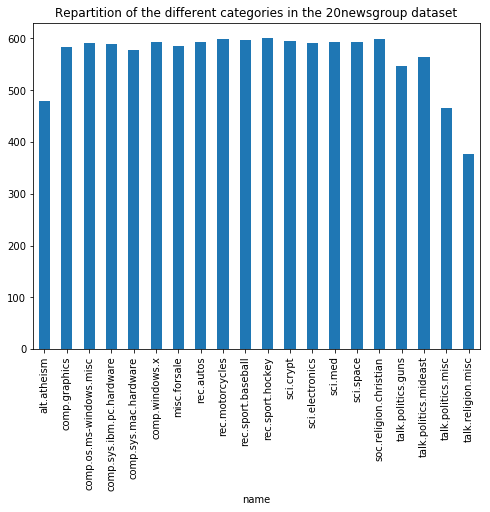

In [12]:
categories = newsgroups.target_names
categories_dict= {idx: c for  idx,c in enumerate(categories)}
categories_df= pd.DataFrame(newsgroups.target,columns=['name'])
categories_df['name']=categories_df['name'].map(categories_dict)

fig = plt.figure(figsize=(8,6))
categories_df.groupby('name')['name'].count().plot('bar',title='Repartition of the different categories in the 20newsgroup dataset')

#### Compute TF-IDF features for every article using TfidfVectorizer

In [13]:
# TfidVectorizer 
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups.data)

print("shape = {0}".format(vectors.shape))
print("Number of non-zero components by sample = {0}".format(vectors.nnz / float(vectors.shape[0])))

shape = (11314, 101631)
Number of non-zero components by sample = 97.54525366802191


The extracted TF-IDF vectors are very sparse, with an average of 97 non-zero components by sample in a more than 100000-dimensional space (less than 0.1% non-zero features):

#### Split the dataset into a training, a testing and a validation set

Then, we splited our dataset into a training, a testing and a validation set (10% for validation and 10% for testing).Using two times the function train_test_split, indicating the ratio. First time to obtain a train set with 80% of the data, and we split in two the other obtained set, to finally have 10% for validation and 10% for testing
We finally created a data frame to pair each observation  with its corresponding label (the article category).

In [14]:
#notation X for features an y for label
#first split 80% train set 20% provisory test set.
X_train,X_test,y_train,y_test= train_test_split(vectors,newsgroups.target,test_size=.2) 
#Split the provisory test set into 50% validation set and test set.
X_validation,X_test,y_validation,y_test= train_test_split(X_test,y_test, test_size=.5)

Pair each observation  with its corresponding label (the article category).

In [15]:
train_set = pd.DataFrame(data=X_train.todense(), index=y_train)
test_set = pd.DataFrame(data=X_test.todense(), index=y_test)
validation_set = pd.DataFrame(data=X_validation.todense(), index=y_validation)

### Task 2


** Random forest classifier **

We trained the Random Forest Classifier (from the sklearn librairy) on our training set to predict the label for our testing set. But first we tried to fine-tune the hyper-parameters of our predictor on our validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". 

- `n_estimators` is the number of trees in the forest.
- `max_depth`  is The maximum depth of the tree, it is important for the bias-variance trade-off.


we created a first rough grid to have an idea of the magnitude of those hyper-parameter.
We implemented a function `grid_search`, which has as

Input:
- `n_grid` the grid for `n_estimators`
- `m_grid` the grid for  `max_depth` 
- `train_set` the train set 
- `validation_set` the validation set

Output:
- `accuracy_grid` the prediction score on the validation set for each combination of `n_estimators` and `max_depth` 
- `n_best` the optimal `n_estimators`
- `m_best` the optimal `max_depth` 

** Confusion Matrix **

Using the best hyper-parameters we trained random forest classifier on the training dataset. And predict the labels for the testing set. We showed the results with a confusion matrix 
We finally inspected the `feature_importances_` attribute of our random forest.

For complitness we also inspected the effect of increasing and decreasing the optimal hyperparameters we found with the gridsearch.

In [30]:
def grid_search(n_grid,m_grid,train_set,validation_set):
    
    accuracy_grid=np.zeros((n_grid.size,m_grid.size))

    for n_idx,n in enumerate(n_grid):
        for m_idx,m in enumerate(m_grid):
            clf = RandomForestClassifier(max_depth=m, n_estimators=n)
            clf.fit(train_set,train_set.index.values)
            accuracy_grid[n_idx,m_idx]=metrics.accuracy_score(validation_set.index.values, clf.predict(validation_set))
        
    best_indices = np.where(accuracy_grid == accuracy_grid.max())

    n_best=n_grid[best_indices[0][0]]
    m_best=m_grid[best_indices[1][0]]
    return accuracy_grid,n_best,m_best

In [31]:

# we create a first rough grid to have an idea of the improvement by increasing n_estimators and max_depth

n_grid=np.array([50, 100, 200 ,500,1000])
m_grid=np.array([50, 100, 200 ,500,1000])

scores,n_best,m_best=grid_search(n_grid,m_grid,train_set,validation_set)

In [35]:
np.save('score1.npy', scores)


The Results of the grid search are plotted below.
Here we see that multiplying by 2 both hyper-parameter from 500 to 1000 we almost not increase the accuracy. And 
from `n_estimaors=200` and `max_depth`=100 to  `n_estimaors=500` and `max_depth`=500 the increase accuracy `0.9%`. Therefore we choose are optimal parameters `n_estimaors=200` and `max_depth`=100. To keep a simple model and avoid overfitting
 

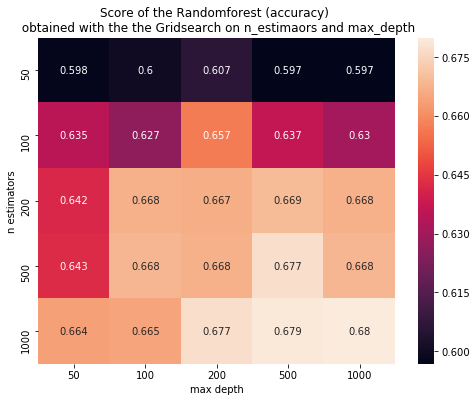

In [41]:
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(scores,annot=True,fmt=".3")
plt.xticks(np.arange(0,len(n_grid),1)+0.5,m_grid);
plt.yticks(np.arange(0,len(m_grid),1)+0.5,m_grid);
plt.xlabel('max depth')
plt.ylabel('n estimators')
plt.title('Score of the Randomforest (accuracy) \n obtained with the the Gridsearch on n_estimaors and max_depth')


After trained our classifier with the optimal parameter. we display a confusion matrix of our classification pipeline. And we inspect the most informative features.
To do this we create a function `plot_confusion_and_feature_importance` which takes as 

Input:
- `clf` the trained classifier
- `test_set` the testing set 

And plot the confusion matrix and gives 10 the most important feature with it's score.



In [43]:
#optimal parameter
n_best=200
m_best=100

# train the classifier on the train set
clf1 = RandomForestClassifier(n_estimators=n_best, max_depth=m_best)
clf1.fit(train_set,train_set.index.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [98]:
def plot_confusion_and_feature_importance(clf,test_set):
    
    #compute the confusion matrix on the test set
    accuracy=metrics.accuracy_score(test_set.index.values, clf.predict(test_set))
    CM=metrics.confusion_matrix(test_set.index.values, clf.predict(test_set))

    fig = plt.figure(figsize=(8,6))
    
    ax = sns.heatmap(CM,annot=True, fmt="d",cmap='Blues')
    x=np.arange(0,20,1)+0.5
    labels=categories
    plt.xticks(x, labels,rotation='vertical');
    plt.yticks(x, labels,rotation='horizontal');
    plt.xlabel('Predicted categories')
    plt.ylabel('True categories')
    plt.title('Confusion matrix of the classification pipeline. Accuracy={:.2%}'.format(accuracy))
    
    index_to_word = {idx: v for v, idx in vectorizer.vocabulary_.items()}

    feature_importance = pd.DataFrame(clf.feature_importances_)
    feature_importance.index = feature_importance.index.map(lambda x: index_to_word[x])

    feature_importance = feature_importance.sort_values(0, axis=0, ascending=False)
    feature_importance.head(10).plot(kind='bar',title = 'The  10 most important features', figsize=(10,5), legend=False)

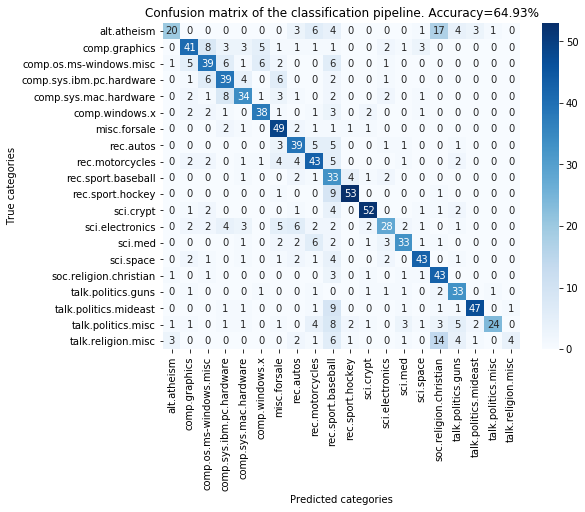

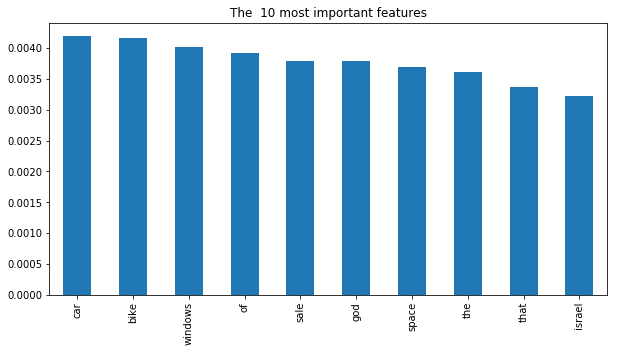

In [99]:
plot_confusion_and_feature_importance(clf1,test_set)

On the diagonal are the well classified article, our classiffier has an accuracy of 65%

It's interesting to compare the 10  `feature_importances_` attribute with the highest score with the Confusion matrix. We see that some word seems indee good to identify some categories, we summarize taking the notation:
- *features name* : categories numbers of True (there are around 50 article of each categorie in the test set)


- *car* : rec.autos  39 
- *bike* : rec.motorcycles 43
- *windows* : comp.windows.x 38
- *sale*: misc.forsale 49
- *god* : soc.religion.christian 43
- *space* : sci.space 43
- *israel*: talk.politics.mideast 47

Supringly stop words as *of*, *the* and *that* are appearing here in the 10  `feature_importances_` attribute

Looking at the most number missclassified article we have:
- 17 alt.atheism as soc.religion.christian 
- 14 talk.religion.misc article precited   as soc.religion.christian
We see clearly that those three categories are linked, for example the word *god* could appear in all of these article, and we see that our classifier seems to favorize the category soc.religion.christian. This could also be explained by the fact that they are more soc.religion.christian articles in the data set than alt.atheism and talk.religion.misc

For curiosity we wanted to see what happen by increasing `n_setimators`, and `max_depth` to 500:

In [44]:
# train the classifier on the train set  with n_estimators=500, max_depth=500
clf2 = RandomForestClassifier(n_estimators=500, max_depth=500)
clf2.fit(train_set,train_set.index.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

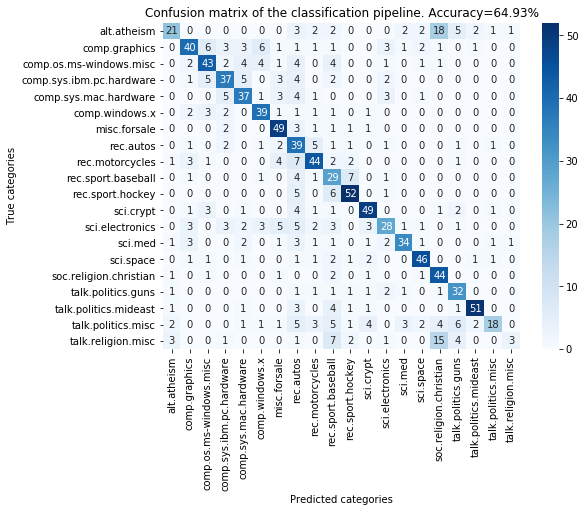

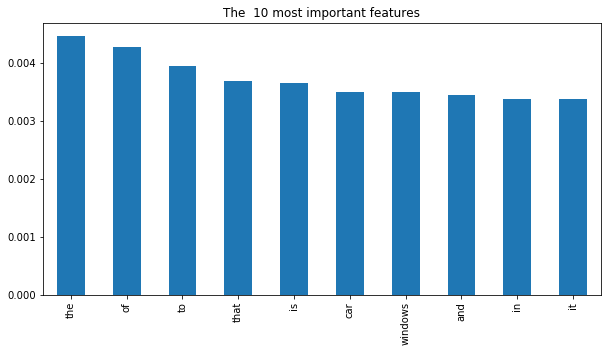

In [100]:
plot_confusion_and_feature_importance(clf2,test_set)

Here we see that the accuracy did not change and we have way more stop words indicate that we are probably overfitting

Now deacrinsing by two our first best hyperparameters. We see that the accuracy deacreased to 60%. But there are no stop-words in the most important features and we see new interesting words explicitly linked to categories like:
- *hockey* : rec.sport.hockey 53
- *apple* : comp.os.ms-windows.misc 38
- *gun* : talk.politics.guns 33


In [95]:
# train the classifier on the train set  with n_estimators=100, max_depth=50
clf3 = RandomForestClassifier(n_estimators=100, max_depth=50)
clf3.fit(train_set,train_set.index.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

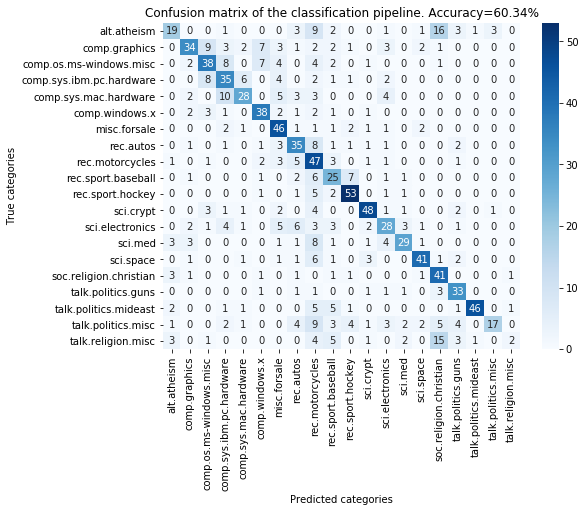

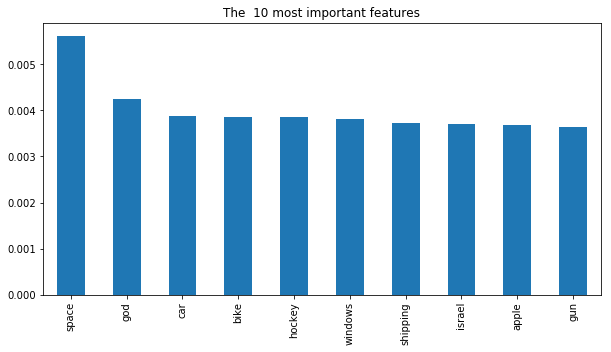

In [101]:
plot_confusion_and_feature_importance(clf3,test_set)